# Grover のアルゴリズム

ここでは Google が開発している cirq を使ってみる。

In [1]:
import cirq

# Pick a qubit
qubits = [cirq.NamedQubit(s) for s in ['{}'.format(i) for i in range(3)]]

# Create a circuit.
circuit = cirq.Circuit(
    cirq.X(qubits[0]),  # Square root of NOT.
    cirq.H(qubits[1]),  # Hadamard.
    cirq.CNOT(qubits[1], qubits[2]),  # Controlled NOT.
    cirq.measure(*qubits[0:2], key="m"),  # Measurement.
    cirq.measure(qubits[2], key='n'), # Measurement.
)
print("Circuit:")
print(circuit)

# simulator.run provides us the samples of the measurement results.
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10)
print("Measurement results:", result.measurements['m'])

Circuit:
0: ───X───────M('m')───
              │
1: ───H───@───M────────
          │
2: ───────X───M('n')───
Measurement results: [[1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 1]
 [1 1]
 [1 0]
 [1 1]
 [1 0]
 [1 1]]


In [2]:
import cirq

# Pick a qubit
qubits = [cirq.NamedQubit(s) for s in ['{}'.format(i) for i in range(3)]]

# Create a circuit.
circuit = cirq.Circuit(
    cirq.X(qubits[0]),  # Square root of NOT.
    cirq.H(qubits[1]),  # Hadamard.
    cirq.CNOT(qubits[1], qubits[2]),  # Controlled NOT.
)
print("Circuit:")
print(circuit)

# simulator.simulate provides us the final state vector.
simulator = cirq.Simulator()
result = simulator.simulate(circuit)
print("Final state vector:", result.final_state_vector)

# you can also add measurements to the circuit, but that makes the simulation probabilistic
circuit.append(cirq.measure(*qubits, key='m'))
result = simulator.simulate(circuit)
print("state vector after measurement:", result.final_state_vector)
print("Measurement results:", result.measurements['m'])

Circuit:
0: ───X───────

1: ───H───@───
          │
2: ───────X───
Final state vector: [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.70710677+0.j 0.        +0.j 0.        +0.j 0.70710677+0.j]
state vector after measurement: [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
Measurement results: [1 0 0]


# グローバーのアルゴリズムを Cirq で実装してみる

In [3]:
import numpy as np


def get_grover_circuit(n_iter, n_qubits):
    qubits = [cirq.NamedQubit(s) for s in ['{}'.format(i) for i in range(n_qubits)]]
    # Create a new circuit for Grover's algorithm
    grover_circuit = cirq.Circuit()
    # Apply Hadamard gates to all qubits to create superposition
    grover_circuit.append(cirq.H.on_each(*qubits))
    for i in range(n_iter):
        oracle = cirq.Z.controlled(num_controls=n_qubits-1).on(*qubits) # flips 1111
        # Apply the oracle that flips the sign of 111..111 state
        grover_circuit.append(oracle)
        reflection = cirq.Circuit()
        reflection.append(cirq.H.on_each(*qubits))
        reflection.append(cirq.X.on_each(*qubits))
        reflection.append(cirq.Z.controlled(num_controls=n_qubits-1).on(*qubits))
        reflection.append(cirq.X.on_each(*qubits))
        reflection.append(cirq.H.on_each(*qubits))
        # Reflection about the |+++..+> state
        grover_circuit.append(reflection)

    return grover_circuit

# Print the Grover circuit
print("Grover Circuit:")
print(get_grover_circuit(1,10))


Grover Circuit:
0: ───H───@───H───X───@───X───H───
          │           │
1: ───H───@───H───X───@───X───H───
          │           │
2: ───H───@───H───X───@───X───H───
          │           │
3: ───H───@───H───X───@───X───H───
          │           │
4: ───H───@───H───X───@───X───H───
          │           │
5: ───H───@───H───X───@───X───H───
          │           │
6: ───H───@───H───X───@───X───H───
          │           │
7: ───H───@───H───X───@───X───H───
          │           │
8: ───H───@───H───X───@───X───H───
          │           │
9: ───H───Z───H───X───Z───X───H───


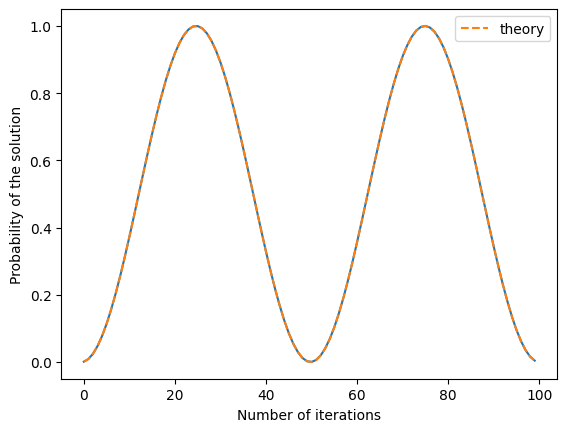

In [4]:
n_max_iter = 100
n_qubits = 10
n_iter_list = np.arange(n_max_iter)
amplitude_list = []
for n_iter in n_iter_list:
    grover_circuit = get_grover_circuit(n_iter, n_qubits)
    simulator = cirq.Simulator()
    result = simulator.simulate(grover_circuit)
    # Check if the state is close to the solution state
    amplitude_list.append(np.abs(result.final_state_vector[-1])**2)
import matplotlib.pyplot as plt
plt.plot(n_iter_list, amplitude_list)

# also plot the theoretical curve
theta = np.arcsin(1/np.sqrt(2**n_qubits))
plt.plot(n_iter_list, np.sin((2*n_iter_list+1)*theta)**2, label="theory", linestyle='dashed')
plt.xlabel('Number of iterations')
plt.ylabel('Probability of the solution')
plt.legend()
plt.show()

# 複数個の解がある場合

も同様の回路で解を見つけだすことができます。Grover のアルゴリズムとも呼ばれますが、このようなケースの場合は amplitude amplification （日本語では振幅増幅）と呼ばれることも多いです。

In [5]:
import numpy as np

def get_grover_circuit_with_multiple_answers(n_iter, n_qubits, n_ans):
    qubits = [cirq.NamedQubit(s) for s in ['{}'.format(i) for i in range(n_qubits)]]
    # Create a new circuit for Grover's algorithm
    grover_circuit = cirq.Circuit()
    # Apply Hadamard gates to all qubits to create superposition
    grover_circuit.append(cirq.H.on_each(*qubits))

    # utility list to store the indices of the answer states
    _ans_index_list = []
    for j in range(n_ans):
        ans_index = bin(j)[2:].zfill(n_qubits-1)
        _ans_index_list.append(int(ans_index+"1", 2))

    for i in range(n_iter):
        for j in range(n_ans):
            ans_index = bin(j)[2:].zfill(n_qubits-1)        
            control_values = [int(ans_index[k]) for k in range(n_qubits-1)]
            oracle = cirq.Z.controlled(num_controls=n_qubits-1, control_values=control_values).on(*qubits)
            # Apply the oracle that flips the sign of |(binary rep of j)1> state
            grover_circuit.append(oracle)
        reflection = cirq.Circuit()
        reflection.append(cirq.H.on_each(*qubits))
        reflection.append(cirq.X.on_each(*qubits))
        reflection.append(cirq.Z.controlled(num_controls=n_qubits-1).on(*qubits))
        reflection.append(cirq.X.on_each(*qubits))
        reflection.append(cirq.H.on_each(*qubits))
        # Reflection about the |+++..+> state
        grover_circuit.append(reflection)

    return grover_circuit, _ans_index_list

# Print the Grover circuit
print("Grover Circuit:")
print(get_grover_circuit_with_multiple_answers(1,10,4)[0])
print("Answers:", get_grover_circuit_with_multiple_answers(1,10,4)[1])


Grover Circuit:
0: ───H───(0)───(0)───(0)───(0)───H───X───@───X───H───
          │     │     │     │             │
1: ───H───(0)───(0)───(0)───(0)───H───X───@───X───H───
          │     │     │     │             │
2: ───H───(0)───(0)───(0)───(0)───H───X───@───X───H───
          │     │     │     │             │
3: ───H───(0)───(0)───(0)───(0)───H───X───@───X───H───
          │     │     │     │             │
4: ───H───(0)───(0)───(0)───(0)───H───X───@───X───H───
          │     │     │     │             │
5: ───H───(0)───(0)───(0)───(0)───H───X───@───X───H───
          │     │     │     │             │
6: ───H───(0)───(0)───(0)───(0)───H───X───@───X───H───
          │     │     │     │             │
7: ───H───(0)───(0)───@─────@─────H───X───@───X───H───
          │     │     │     │             │
8: ───H───(0)───@─────(0)───@─────H───X───@───X───H───
          │     │     │     │             │
9: ───H───Z─────@─────Z─────Z─────H───X───Z───X───H───
Answers: [1, 3, 5, 7]


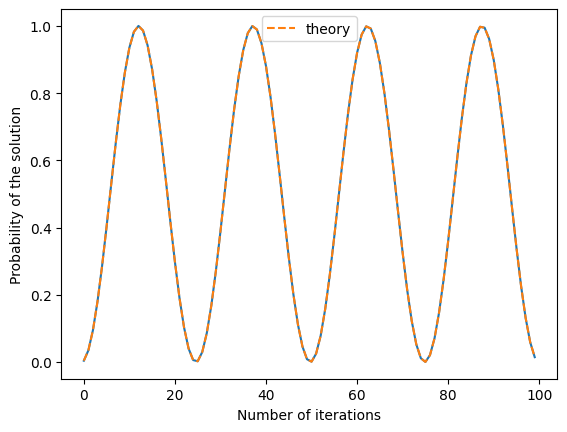

In [6]:
n_max_iter = 100
n_qubits = 10
n_ans = 4
n_iter_list = np.arange(n_max_iter)
amplitude_list = []
for n_iter in n_iter_list:
    grover_circuit, ans_index_list = get_grover_circuit_with_multiple_answers(n_iter, n_qubits, n_ans)
    simulator = cirq.Simulator()
    result = simulator.simulate(grover_circuit)
    # calculate the ampliude of the answer states
    answer_amplitude_list = np.abs(result.final_state_vector[ans_index_list])**2
    amplitude_list.append(np.sum(answer_amplitude_list))
import matplotlib.pyplot as plt
plt.plot(n_iter_list, amplitude_list)

# also plot the theoretical curve
theta = np.arcsin(np.sqrt(n_ans)/np.sqrt(2**n_qubits))
plt.plot(n_iter_list, np.sin((2*n_iter_list+1)*theta)**2, label="theory", linestyle='dashed')
plt.xlabel('Number of iterations')
plt.ylabel('Probability of the solution')
plt.legend()
plt.show()

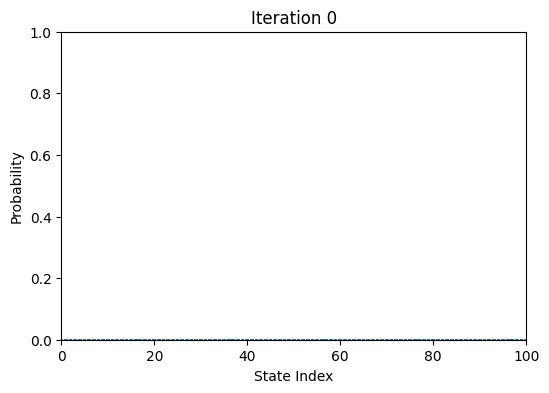

In [7]:
# animate how the probability of the answer states change with the number of iterations
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

n_max_iter = 100
n_qubits = 10
n_ans = 4
n_iter_list = np.arange(n_max_iter)

# Initialize figure
fig, ax = plt.subplots(figsize=(6, 4))
x = np.arange(2**n_qubits)
bar_container = ax.bar(x, np.ones_like(x)/2**n_qubits)

ax.set_ylim(0, 1)
ax.set_xlim(0, 100)
ax.set_xlabel("State Index")
ax.set_ylabel("Probability")
ax.set_title("Evolution of State Probabilities in Grover's Algorithm")

# Update function for animation
def update(n_iter):
    grover_circuit, ans_index_list = get_grover_circuit_with_multiple_answers(n_iter, n_qubits, n_ans)
    simulator = cirq.Simulator()
    result = simulator.simulate(grover_circuit)
    probabilities = np.abs(result.final_state_vector) ** 2

    # Update bars
    for bar, p in zip(bar_container, probabilities):
        bar.set_height(p)
    
    ax.set_title(f"Iteration {n_iter}")

# Create animation
ani = animation.FuncAnimation(fig, update, frames=n_iter_list, repeat=False, interval=100)

# Save animation as HTML and display
HTML(ani.to_jshtml())

解ベクトルが一様に増減を繰り返すことがわかります。

# 発展：Fixed point amplitude amplification

Grover のアルゴリズムでは Grover iteration を作用させると状態が回転します。このため高い確率で「解」を得たい時には、解の個数に応じて異なる回数だけ Grover iteration を適用する必要があります。これは解の個数を事前に知っている場合には問題ありませんが、解の個数を事前に知らない場合には問題があります。

amplitude amplification の原論文などではある一定の手順で Grover iteration の回数を増やしていく方法が提案されていますが、より簡単な手続きで解を得る方法があります。それが Fixed point amplitude amplification です。

https://arxiv.org/pdf/1409.3305 をそのまま実装してみます

In [ ]:
def get_fpaa_circuit_with_multiple_answers(n_iter, n_qubits, n_ans, delta=0.1):
    
    qubits = [cirq.NamedQubit(s) for s in ['{}'.format(i) for i in range(n_qubits)]]
    # Create a new circuit for Grover's algorithm
    grover_circuit = cirq.Circuit()
    # Apply Hadamard gates to all qubits to create superposition
    grover_circuit.append(cirq.H.on_each(*qubits))
    
    # utility list to store the indices of the answer states
    _ans_index_list = []
    for j in range(n_ans):
        ans_index = bin(j)[2:].zfill(n_qubits-1)
        _ans_index_list.append(int(ans_index+"1", 2))

    # prepare phase
    L = 2*n_iter + 1
    gamma = 1/np.cos(np.arccos(1/delta, dtype=complex)/L, dtype=complex)
    phases = [2*np.arctan(1/(np.tan(2*np.pi*(j+1)/L) * np.sqrt(1 - gamma**2))) for j in range(n_iter)]

    for i in range(n_iter):
        alpha_i = phases[i]
        beta_i = phases[n_iter - i - 1]
        for j in range(n_ans):
            ans_index = bin(j)[2:].zfill(n_qubits-1)        
            control_values = [int(ans_index[k]) for k in range(n_qubits-1)]
            # ZPowGate(t) is diag(1,e^{ipi t})
            oracle = cirq.ZPowGate(exponent=beta_i/np.pi).controlled(num_controls=n_qubits-1, control_values=control_values).on(*qubits)
            # Apply the oracle that flips the sign of |(binary rep of j)1> state
            grover_circuit.append(oracle)
        reflection = cirq.Circuit()
        reflection.append(cirq.H.on_each(*qubits))
        reflection.append(cirq.X.on_each(*qubits))
        reflection.append(cirq.ZPowGate(exponent=alpha_i/np.pi).controlled(num_controls=n_qubits-1).on(*qubits))
        reflection.append(cirq.X.on_each(*qubits))
        reflection.append(cirq.H.on_each(*qubits))
        # Reflection about the |+++..+> state
        grover_circuit.append(reflection)

    return grover_circuit, _ans_index_list


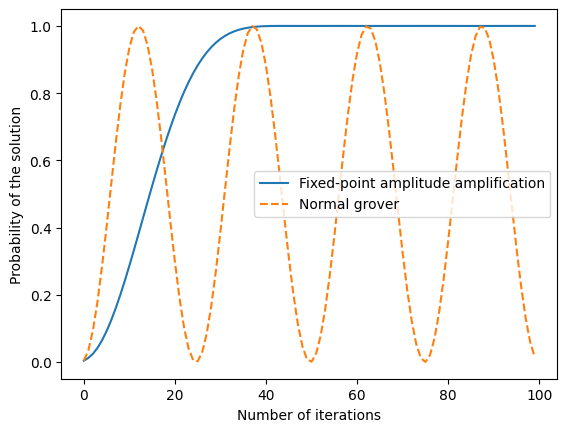

In [24]:
n_max_iter = 100
n_qubits = 10
n_ans = 4
delta = 0.01 # error probability tolerance
n_iter_list = np.arange(n_max_iter)
amplitude_list = []
for n_iter in n_iter_list:
    grover_circuit, ans_index_list = get_fpaa_circuit_with_multiple_answers(n_iter, n_qubits, n_ans, delta=delta)
    simulator = cirq.Simulator()
    result = simulator.simulate(grover_circuit)
    # calculate the ampliude of the answer states
    answer_amplitude_list = np.abs(result.final_state_vector[ans_index_list])**2
    amplitude_list.append(np.sum(answer_amplitude_list))
import matplotlib.pyplot as plt
plt.plot(n_iter_list, amplitude_list, label="Fixed-point amplitude amplification")

# also plot the theoretical curve
theta = np.arcsin(np.sqrt(n_ans)/np.sqrt(2**n_qubits))
plt.plot(n_iter_list, np.sin((2*n_iter_list+1)*theta)**2, label="Normal grover", linestyle='dashed')
plt.xlabel('Number of iterations')
plt.ylabel('Probability of the solution')
plt.legend()
plt.show()